## 1. Introduction
In this article, the emotion distribution learning to determine the emotion distribution for the given images is proposed. Here a current state-of-the-art algorithm model which have the distribution specific loss is considered as a reference and proper modelling of the correlation for the image emotion distribution learning is added as the additional feature. For a particular image, the emotion recognized will vary when the model used in it varies. So here the graph convolutional network is used for capturing the hidden relationship in the graph data which will be formed by converting each pixel into the graph with equivalent number of nodes. This emotion correlation matrix represents the probability distribution of the particular emotion from which any test data can be recognized. 

In [48]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv
import random
from sklearn.preprocessing import LabelEncoder
import glob
import time
import pickle
import pandas as pd
from pathlib import Path
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras.backend as K
from keras.layers import Input, Dense, Flatten
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from spektral.layers import GraphConv, GlobalAvgPool, EdgeConditionedConv
from spektral.utils import Batch, batch_iterator
from spektral.utils import label_to_one_hot, normalized_laplacian
from spektral.layers.ops import sp_matrix_to_sp_tensor
import graph
import networkx as nx
import scipy.sparse as sp
from spektral.datasets import mnist
from keras.layers import MaxPooling2D, Reshape
from spektral.layers import GraphConv, ChebConv
from spektral.utils import localpooling_filter
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from utilities import generate_graph,create_graph

In [49]:
train_path = 'C:\\Users\\ACER\\Desktop\\Emotion_detection\\train_trim'
# Parameters
user_reguralization_rate = 5e-4         
user_model_learning_rate = 0.03  
user_model_batch = 32    
epochs = 80    
print(train_path)

C:\Users\ACER\Desktop\Emotion_detection\train_trim


In [50]:
# folder preprocessing 

def check_folder_path(path):   
    if not Path.is_dir(path):   
        raise ValueError("argument is not directory")   
       
    yield from filter(Path.is_dir, path.iterdir())


def check_depth(path, depth):
    if 0 > depth:
        raise ValueError("depth smaller 0")
    if 0 == depth:
        yield from check_folder_path(path)
    else:
        for folder in check_folder_path(path):
            yield from check_depth(folder, depth - 1)


def check_files(path):
    if not Path.is_dir(path):
        raise ValueError("argument is not a directory")
    yield from filter(Path.is_file, path.iterdir())


def sum_file_size(filepaths):
    return sum([filep.stat().st_size for filep in filepaths])


def convert_image_to_array(image_dir):
    try:
        image = cv.imread(image_dir)

        if image is not None:

            image1 = cv.resize(image, default_image_size)
            gray = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)

            return img_to_array(gray).flatten()
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

def graph_convolution_one_layer_model(A, N=28 * 28, F=1,n_out=10,l2_reg=user_reguralization_rate,
                     learning_rate=user_model_learning_rate,
                     ):
    """
    Creating a simple single layer GCN
    """

    L = localpooling_filter(A)

    X_in = Input(shape=(N, F)) # N=nodes and F=features dimension

    A_in = Input(tensor=sp_matrix_to_sp_tensor(L))

    graph_conv = GraphConv(10,
                           activation='relu',
                           kernel_regularizer=l2(l2_reg),
                           use_bias=True)([X_in, A_in])

    fc = Flatten()(graph_conv)
    output = Dense(n_out, activation='softmax')(fc)

    # Build model
    model = Model(inputs=[X_in, A_in], outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def graph_convolution_network(A, N=28 * 28, F=1,
        n_out=10,
        l2_reg=user_reguralization_rate,
        learning_rate=user_model_learning_rate,
        ):
    """
    Creating two layer GCN
    """
    
    L = localpooling_filter(A)
    X_in = Input(shape=(N, F))
    A_in = Input(tensor=sp_matrix_to_sp_tensor(L))

    graph_conv = GraphConv(32,
                           activation='relu',
                           kernel_regularizer=l2(l2_reg),
                           use_bias=True)([X_in, A_in])
    graph_conv = GraphConv(32,
                           activation='relu',
                           kernel_regularizer=l2(l2_reg),
                           use_bias=True)([graph_conv, A_in])

    rs = Reshape((28, 28, 32))(graph_conv)
    pooled = MaxPooling2D(pool_size=(2, 2))(rs)
    flatten = Flatten()(pooled)
    fc = Dense(512, activation='relu')(flatten)
    output = Dense(n_out, activation='softmax')(fc)
    # Build model
    model = Model(inputs=[X_in, A_in], outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [51]:
image_list, label_list = [], []
train_labels = os.listdir(train_path)  # take training path labels
num_labels=len(train_labels)
print(num_labels)
train_labels.sort()  # sort the labels
print(train_labels)  # primt the lables
labels = []  # create label variables so as to decode text to number
total = 0  # initialize
tot_file = []  # initialize
count = 1  # start count to check number of images
i = 0
j = 0
k = 0
print(Path.cwd())  # gives the current path
for folder in check_depth(Path.cwd(), 1):
    # first loop will pick the first foldend then next folder
    files = list(check_files(folder))  # list all files in folder
    file = len(files)  # length of files
    tot_file.append(file)  # because we are running for all folder
    # we are appending all files in tot_file at the end we
    # shall get the list of number of files in the folder
    # we are doing this because every folder has different number of files
    # at the end when we are trainig all class of disease have to be
    # trained equally, hence find the least number of images in the folder
    # and then train accordingly
    total_size = sum_file_size(files)
    # total size of files
    count = count + 1  # check total number of files executed
    print(f'{folder}:filecount:{len(files)},total size:{total_size}')

tot_file.sort()  # sort files based on ascending order
num = int(tot_file[1])  # Index 0 is junkhence extract index 1

print('tOTAL FILE:', tot_file)
print(num)

images_per_class = 3200 # consider number of images per class
# %%START WITH TRAINING
# for tr_name in range(0,2):
count = 0
default_image_size = tuple((28, 28))

for count in range(0, len(train_labels)):

    tr_name = count

    dir = train_path + '\\' + train_labels[tr_name]
#     print(dir)
    current_label = train_labels[tr_name]
    print("[STATUS] processed folder: {}".format(current_label))
    k = 1
    file_sub_folder = os.listdir(dir)
#     print(file_sub_folder)
    for x in range(0, images_per_class):
        file = dir + '\\' + file_sub_folder[x]
#         print(file)
        image_list.append(convert_image_to_array(file))
        label_list.append(current_label)
        i += 1
        k += 1
        count = count + 1
print("[STATUS] training labels{}".format(np.array(label_list).shape))
labelEncoder = LabelEncoder()
image_size = len(image_list)
image_labels = labelEncoder.fit_transform(label_list)

np_image_list = np.array(image_list, dtype=np.float32) / 225.0
print("[INFO] Spliting data to train, test")
X_train, X_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state=42)
X_val = X_test
y_val = y_test

4
['angry', 'happy', 'sad', 'surprise']
C:\Users\ACER\Desktop\Emotion_detection
C:\Users\ACER\Desktop\Emotion_detection\.idea\inspectionProfiles:filecount:1,total size:174
C:\Users\ACER\Desktop\Emotion_detection\gcn1\conda-meta:filecount:61,total size:11459445
C:\Users\ACER\Desktop\Emotion_detection\gcn1\DLLs:filecount:34,total size:10595549
C:\Users\ACER\Desktop\Emotion_detection\gcn1\include:filecount:102,total size:656144
C:\Users\ACER\Desktop\Emotion_detection\gcn1\Lib:filecount:172,total size:4325196
C:\Users\ACER\Desktop\Emotion_detection\gcn1\Library:filecount:0,total size:0
C:\Users\ACER\Desktop\Emotion_detection\gcn1\libs:filecount:3,total size:512288
C:\Users\ACER\Desktop\Emotion_detection\gcn1\Scripts:filecount:83,total size:13221247
C:\Users\ACER\Desktop\Emotion_detection\gcn1\share:filecount:0,total size:0
C:\Users\ACER\Desktop\Emotion_detection\gcn1\sip:filecount:0,total size:0
C:\Users\ACER\Desktop\Emotion_detection\gcn1\tcl:filecount:6,total size:1600642
C:\Users\ACER\D

In [52]:
gen_random_seed = 2000
os.environ['PYTHONHASHSEED']=str(gen_random_seed)
random.seed(gen_random_seed)
np.random.seed(gen_random_seed)
tf.compat.v1.random.set_random_seed(gen_random_seed)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)


### Splitting the dataset

In [53]:
X_train, X_val, X_test = X_train[..., None], X_val[..., None], X_test[..., None]
N = X_train.shape[-2]      # Number of nodes in the graphs
F = X_train.shape[-1]      # Node features dimensionality
n_out = 10  # Dimension of the target
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(10240, 784, 1) (10240,)
(2560, 784, 1) (2560,)
(2560, 784, 1) (2560,)


### Creating graph with same dimension of images
1. Create a grid the same orientation as the training picture.
2. Find the embedding of the grid.
3. Generate the compressed sparse row (CSR) matrix.
4. Create two graph object with the CSR matrix. One is a complete graph and another one is after removing all the nodes without edges.
5. Find the degree matrix for the graph and repeat the steps for that matrix.

3198 > 3136 edges
Number of nodes: 784; Number of edges: 3198
Number of nodes: 784; Number of edges: 3198
After removing nodes without edges:
Number of nodes: 784; Number of edges: 3198
Number of nodes: 784; Number of edges: 3198
Number of nodes: 784; Number of edges: 3198
After removing nodes without edges:
Number of nodes: 784; Number of edges: 3198


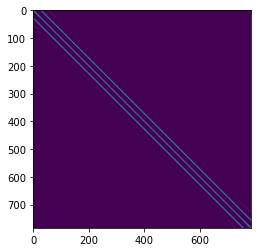

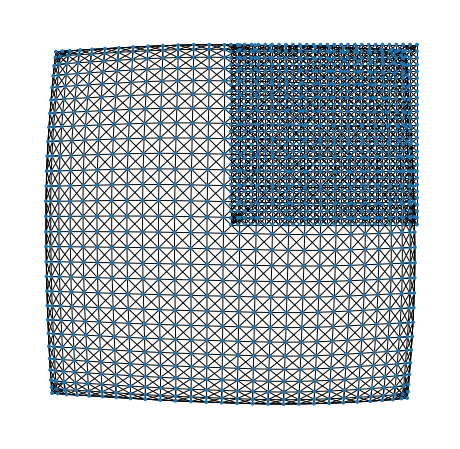

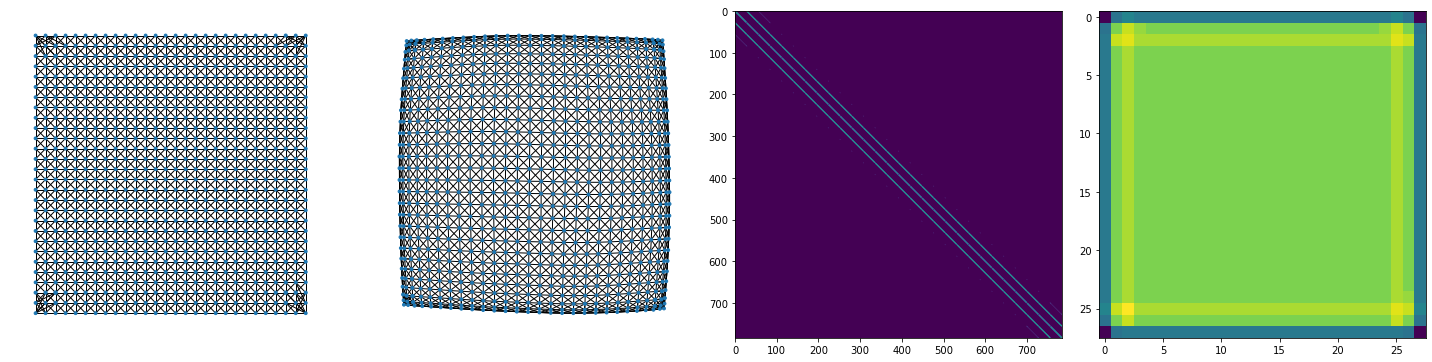

In [54]:
A = generate_graph(28, 8)
plt.imshow(A.todense())
fig, ax = plt.subplots(figsize=(8, 8))
ax = create_graph(A, ax=ax, size_factor=1)
ax = create_graph(A, ax=ax, size_factor=1, spring_layout=True)
fig, axes = plt.subplots(figsize=(20, 5), ncols=4)
axes[2].imshow(A.todense())
 
# degree matrix D
D = A.sum(axis=0).reshape(28, 28)
axes[3].imshow(D)
 
axes[0] = create_graph(A, ax=axes[0], size_factor=1)
axes[1] = create_graph(A, ax=axes[1], size_factor=1, spring_layout=True)
fig.tight_layout()

threshold = 0.25  # to reduce the noise for averaged signals
# threshold = 0.5
d_emotion_graphs = {}  # to collect feature graphs from each class


### Creating sample graphs for each class of emotions

Number of nodes: 784; Number of edges: 3198
Number of nodes: 784; Number of edges: 3198
After removing nodes without edges:
Number of nodes: 784; Number of edges: 3198


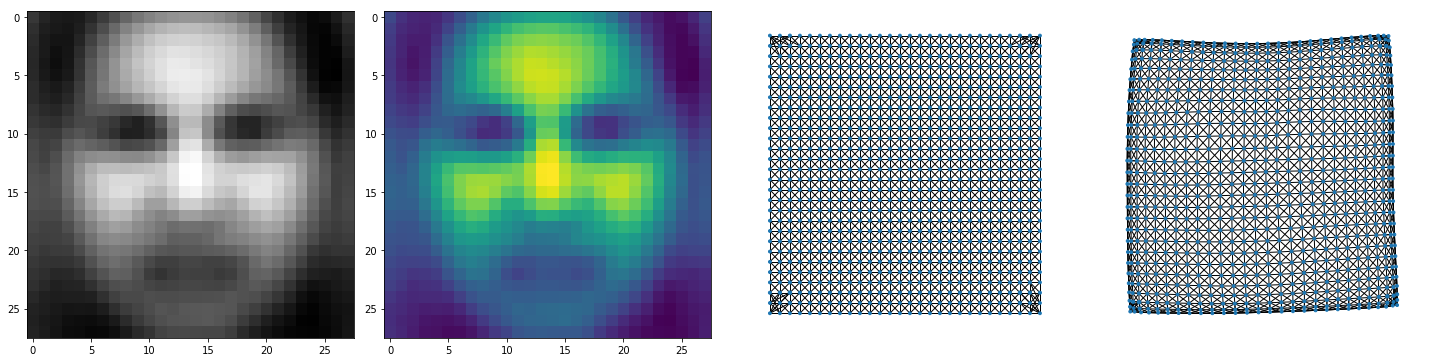

Number of nodes: 784; Number of edges: 3198
Number of nodes: 784; Number of edges: 3198
After removing nodes without edges:
Number of nodes: 784; Number of edges: 3198


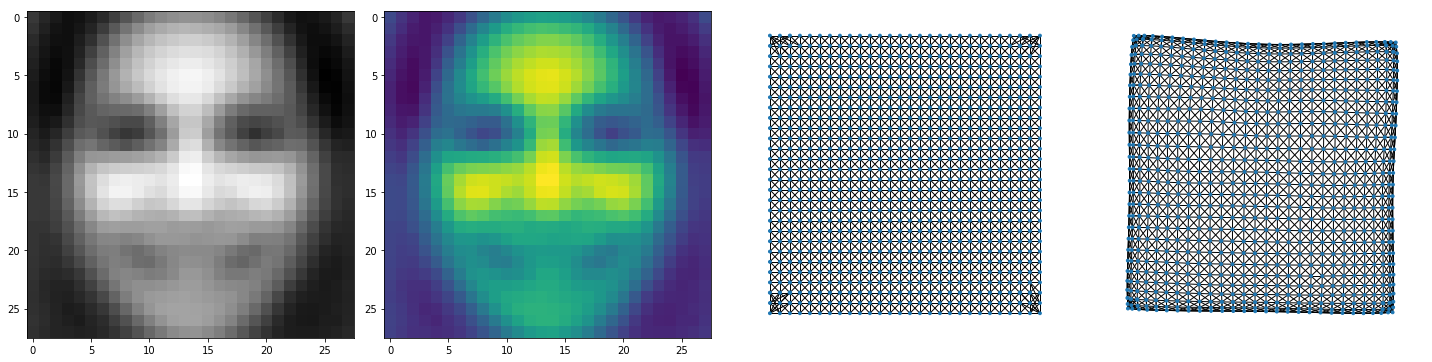

Number of nodes: 784; Number of edges: 3198
Number of nodes: 784; Number of edges: 3198
After removing nodes without edges:
Number of nodes: 784; Number of edges: 3198


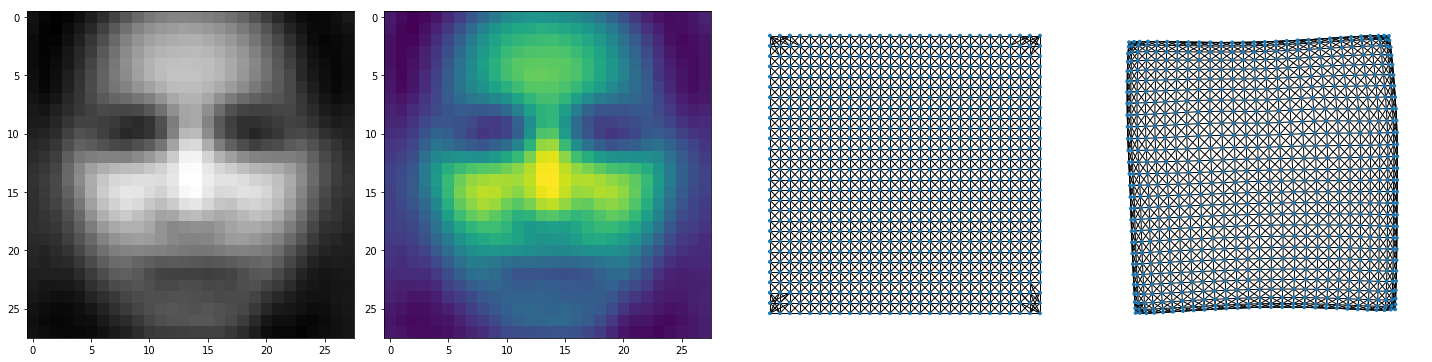

Number of nodes: 784; Number of edges: 3198
Number of nodes: 784; Number of edges: 3198
After removing nodes without edges:
Number of nodes: 784; Number of edges: 3198


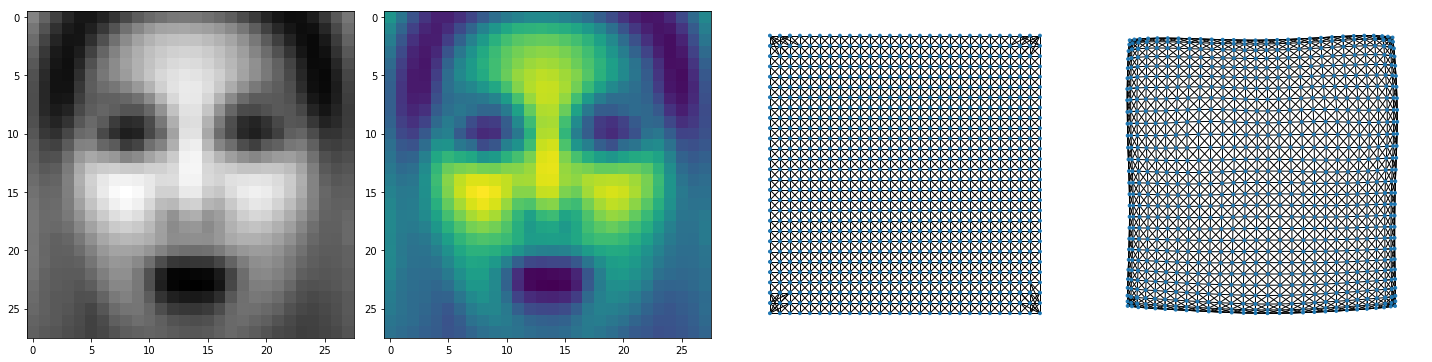

In [55]:
for i in range(num_labels):
    mask = y_train == i
    fig, axes = plt.subplots(figsize=(20, 5), ncols=4)
    x_train_i_avg = X_train[mask].mean(axis=0).flatten()
    axes[0].imshow(x_train_i_avg.reshape(28, 28),cmap='gray')
    # threshold the averages of pixels
    x_train_i_avg[x_train_i_avg < threshold] = 0
    axes[1].imshow(x_train_i_avg.reshape(28, 28))
    # a sparse diag matrix with the intensities values on the diagnoal
    A_diag_i = sp.diags(x_train_i_avg, dtype=np.float32).tolil()
    A_i = A.dot(A_diag_i)
    d_emotion_graphs[i] = A_i
    axes[2] = create_graph(A_i, ax=axes[2], size_factor=1)
    axes[3] = create_graph(A_i, ax=axes[3], size_factor=1, spring_layout=True)
    fig.tight_layout()
    plt.show()



### Training the data with single layer GCN

In [56]:
# --------------graph_convolution_one_layer_model-----------
print("=========== -graph_convolution_one_layer_model- ============")
test_scores = []
model_full_grid = graph_convolution_one_layer_model(A)
model_full_grid.summary()
validation_data = (X_val, y_val)
model_full_grid.fit(X_train,
                    y_train,
                    batch_size=user_model_batch,
                    validation_data=validation_data,
                    epochs=epochs)
print('Evaluating model.')
eval_results = model_full_grid.evaluate(X_test,
                              y_test,
                              batch_size=user_model_batch)
print('loss:{}\n' 
      'acc: {}'.format(*eval_results))

test_scores.append({
    'model': 'graph_convolution_one_layer_model',
    'accuracy': eval_results[1]
})


=========== -graph_convolution_one_layer_model- ============
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 784, 1)       0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           (784, 784)           0                                            
__________________________________________________________________________________________________
graph_conv_13 (GraphConv)       (None, 784, 10)      20          input_22[0][0]                   
                                                                 input_23[0][0]                   
__________________________________________________________________________________________________
flatten_12 (Flatten)          

10240/10240 [==============================] - 5s 473us/step - loss: 1.0462 - acc: 0.5637 - val_loss: 1.1897 - val_acc: 0.4793
Epoch 48/80
10240/10240 [==============================] - 5s 477us/step - loss: 1.0458 - acc: 0.5644 - val_loss: 1.2327 - val_acc: 0.4727
Epoch 49/80
10240/10240 [==============================] - 5s 495us/step - loss: 1.0460 - acc: 0.5649 - val_loss: 1.2093 - val_acc: 0.4789
Epoch 50/80
10240/10240 [==============================] - 5s 475us/step - loss: 1.0461 - acc: 0.5586 - val_loss: 1.1936 - val_acc: 0.4820
Epoch 51/80
10240/10240 [==============================] - 5s 474us/step - loss: 1.0428 - acc: 0.5631 - val_loss: 1.1947 - val_acc: 0.4832
Epoch 52/80
10240/10240 [==============================] - 5s 501us/step - loss: 1.0419 - acc: 0.5655 - val_loss: 1.2188 - val_acc: 0.4859
Epoch 53/80
10240/10240 [==============================] - 5s 474us/step - loss: 1.0377 - acc: 0.5697 - val_loss: 1.1966 - val_acc: 0.4867
Epoch 54/80
10240/10240 [==============

### Training the data with multi layer GCN

In [57]:
# --------------graph_convolution_multi_layer_model-----------
print("=========== -graph_convolution_multi_layer_model- ============")
test_scores = []
model_full_grid = graph_convolution_network(A)
model_full_grid.summary()
validation_data = (X_val, y_val)
model_full_grid.fit(X_train,
                    y_train,
                    batch_size=user_model_batch,
                    validation_data=validation_data,
                    epochs=epochs)
print('Evaluating model.')
eval_results = model_full_grid.evaluate(X_test,
                              y_test,
                              batch_size=user_model_batch)
print('loss:{}\n' 
      'acc: {}'.format(*eval_results))

test_scores.append({
    'model': 'graph_convolution_multi_layer_model',
    'accuracy': eval_results[1]
})

=========== -graph_convolution_multi_layer_model- ============
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 784, 1)       0                                            
__________________________________________________________________________________________________
input_25 (InputLayer)           (784, 784)           0                                            
__________________________________________________________________________________________________
graph_conv_14 (GraphConv)       (None, 784, 32)      64          input_24[0][0]                   
                                                                 input_25[0][0]                   
__________________________________________________________________________________________________
graph_conv_15 (GraphConv)   

10240/10240 [==============================] - 59s 6ms/step - loss: 0.1202 - acc: 0.9685 - val_loss: 2.8247 - val_acc: 0.5230
Epoch 42/80
10240/10240 [==============================] - 60s 6ms/step - loss: 0.1218 - acc: 0.9690 - val_loss: 2.8291 - val_acc: 0.5195
Epoch 43/80
10240/10240 [==============================] - 59s 6ms/step - loss: 0.1146 - acc: 0.9718 - val_loss: 3.0301 - val_acc: 0.5188
Epoch 44/80
10240/10240 [==============================] - 59s 6ms/step - loss: 0.0852 - acc: 0.9832 - val_loss: 3.0354 - val_acc: 0.5180
Epoch 45/80
10240/10240 [==============================] - 59s 6ms/step - loss: 0.0954 - acc: 0.9804 - val_loss: 3.0900 - val_acc: 0.5258
Epoch 46/80
10240/10240 [==============================] - 59s 6ms/step - loss: 0.1256 - acc: 0.9654 - val_loss: 2.9120 - val_acc: 0.5246
Epoch 47/80
10240/10240 [==============================] - 59s 6ms/step - loss: 0.0958 - acc: 0.9781 - val_loss: 3.1255 - val_acc: 0.5207
Epoch 48/80
10240/10240 [=====================

### Training the data with fully connected GCN

In [58]:
A0 = sp.csr_matrix(A.shape, dtype=np.float32)
print(A0.shape, A0.nnz)
model_no_graph = graph_convolution_one_layer_model(A0)
model_no_graph.summary()
model_no_graph.fit(X_train,
                    y_train,
                    batch_size=user_model_batch,
                    validation_data=validation_data,
                    epochs=epochs)
print('Evaluating model.')
eval_results = model_no_graph.evaluate(X_test,
                              y_test,
                              batch_size=user_model_batch)
print('loss: {}\n'
      'acc: {}'.format(*eval_results))

test_scores.append({
    'model': 'GCN graph',
    'accuracy': eval_results[1]
})


def fc_model(N=28 * 28, F=1,
             n_out=10,
             l2_reg=user_reguralization_rate,
             learning_rate=user_model_learning_rate):
    '''-connected model classification.
    '''
    X_in = Input(shape=(N, F))

    fc = Dense(10, activation='relu',
               kernel_regularizer=l2(l2_reg),
               use_bias=True)(Flatten()(X_in))

    output = Dense(n_out, activation='softmax')(fc)

    # Build model
    model = Model(inputs=X_in, outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

model_fc = fc_model()
model_fc.summary()
model_fc.fit(X_train,
                    y_train,
                    batch_size=user_model_batch,
                    validation_data=validation_data,
                    epochs=epochs)


(784, 784) 0
Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           (None, 784, 1)       0                                            
__________________________________________________________________________________________________
input_27 (InputLayer)           (784, 784)           0                                            
__________________________________________________________________________________________________
graph_conv_16 (GraphConv)       (None, 784, 10)      20          input_26[0][0]                   
                                                                 input_27[0][0]                   
__________________________________________________________________________________________________
flatten_14 (Flatten)            (None, 7840)         0           graph_conv_16

10240/10240 [==============================] - 4s 405us/step - loss: 1.0197 - acc: 0.5739 - val_loss: 1.2126 - val_acc: 0.4750
Epoch 49/80
10240/10240 [==============================] - 4s 384us/step - loss: 1.0167 - acc: 0.5756 - val_loss: 1.2036 - val_acc: 0.4852
Epoch 50/80
10240/10240 [==============================] - 4s 384us/step - loss: 1.0118 - acc: 0.5784 - val_loss: 1.2660 - val_acc: 0.4621
Epoch 51/80
10240/10240 [==============================] - 4s 384us/step - loss: 1.0059 - acc: 0.5836 - val_loss: 1.2342 - val_acc: 0.4770
Epoch 52/80
10240/10240 [==============================] - 4s 407us/step - loss: 0.9978 - acc: 0.5875 - val_loss: 1.1995 - val_acc: 0.4789
Epoch 53/80
10240/10240 [==============================] - 4s 386us/step - loss: 1.0044 - acc: 0.5803 - val_loss: 1.2469 - val_acc: 0.4668
Epoch 54/80
10240/10240 [==============================] - 4s 386us/step - loss: 0.9999 - acc: 0.5876 - val_loss: 1.1998 - val_acc: 0.4773
Epoch 55/80
10240/10240 [==============

10240/10240 [==============================] - 1s 79us/step - loss: 1.1622 - acc: 0.4961 - val_loss: 1.2014 - val_acc: 0.4723
Epoch 20/80
10240/10240 [==============================] - 1s 70us/step - loss: 1.1600 - acc: 0.4971 - val_loss: 1.2254 - val_acc: 0.4539
Epoch 21/80
10240/10240 [==============================] - 1s 67us/step - loss: 1.1593 - acc: 0.4962 - val_loss: 1.2010 - val_acc: 0.4719
Epoch 22/80
10240/10240 [==============================] - 1s 68us/step - loss: 1.1575 - acc: 0.5002 - val_loss: 1.2223 - val_acc: 0.4527
Epoch 23/80
10240/10240 [==============================] - 1s 68us/step - loss: 1.1581 - acc: 0.5009 - val_loss: 1.2046 - val_acc: 0.4594
Epoch 24/80
10240/10240 [==============================] - 1s 69us/step - loss: 1.1546 - acc: 0.4998 - val_loss: 1.2045 - val_acc: 0.4758
Epoch 25/80
10240/10240 [==============================] - 1s 68us/step - loss: 1.1495 - acc: 0.5044 - val_loss: 1.2177 - val_acc: 0.4688
Epoch 26/80
10240/10240 [=====================

10240/10240 [==============================] - 1s 68us/step - loss: 1.1061 - acc: 0.5262 - val_loss: 1.2140 - val_acc: 0.4625
Epoch 78/80
10240/10240 [==============================] - 1s 67us/step - loss: 1.1023 - acc: 0.5316 - val_loss: 1.2088 - val_acc: 0.4781
Epoch 79/80
10240/10240 [==============================] - 1s 67us/step - loss: 1.0978 - acc: 0.5294 - val_loss: 1.2037 - val_acc: 0.4785
Epoch 80/80
10240/10240 [==============================] - 1s 67us/step - loss: 1.1035 - acc: 0.5294 - val_loss: 1.1917 - val_acc: 0.4793


In [59]:
# Evaluate model
print('Evaluating model.')
eval_results = model_fc.evaluate(X_test,
                              y_test,
                              batch_size=user_model_batch)
print('Done.\n'
      'Test loss: {}\n'
      'Test acc: {}'.format(*eval_results))

test_scores.append({
    'model': 'connected model',
    'accuracy': eval_results[1]
})

Evaluating model.
2560/2560 [==============================] - 0s 47us/step
Done.
Test loss: 1.1917159155011177
Test acc: 0.479296875


### Training each class separately with single layer GCN

In [60]:
d_emotion_models = {}
for emotion in range(num_labels):
    model_i = graph_convolution_one_layer_model(d_emotion_graphs[emotion])
    print(emotion, d_emotion_graphs[emotion].nnz)

    # Train model with emotion feature graph
    model_i.fit(X_train,
                        y_train,
                        batch_size=user_model_batch,
                        validation_data=validation_data,
                        epochs=epochs)
    
    d_emotion_models[emotion] = model_i

0 6396
Train on 10240 samples, validate on 2560 samples
Epoch 1/80
10240/10240 [==============================] - 6s 569us/step - loss: 1.3482 - acc: 0.3524 - val_loss: 1.3057 - val_acc: 0.3859
Epoch 2/80
10240/10240 [==============================] - 5s 443us/step - loss: 1.2545 - acc: 0.4275 - val_loss: 1.2619 - val_acc: 0.4344
Epoch 3/80
10240/10240 [==============================] - 5s 443us/step - loss: 1.2205 - acc: 0.4528 - val_loss: 1.2168 - val_acc: 0.4637
Epoch 4/80
10240/10240 [==============================] - 4s 421us/step - loss: 1.2044 - acc: 0.4639 - val_loss: 1.2485 - val_acc: 0.4414
Epoch 5/80
10240/10240 [==============================] - 4s 422us/step - loss: 1.1962 - acc: 0.4703 - val_loss: 1.2721 - val_acc: 0.4523
Epoch 6/80
10240/10240 [==============================] - 4s 420us/step - loss: 1.1925 - acc: 0.4752 - val_loss: 1.2030 - val_acc: 0.4582
Epoch 7/80
10240/10240 [==============================] - 5s 441us/step - loss: 1.1845 - acc: 0.4787 - val_loss: 1.2

10240/10240 [==============================] - 4s 415us/step - loss: 1.0923 - acc: 0.5333 - val_loss: 1.1695 - val_acc: 0.4906
Epoch 60/80
10240/10240 [==============================] - 4s 415us/step - loss: 1.0833 - acc: 0.5355 - val_loss: 1.1787 - val_acc: 0.4820
Epoch 61/80
10240/10240 [==============================] - 4s 438us/step - loss: 1.0890 - acc: 0.5344 - val_loss: 1.1651 - val_acc: 0.4844
Epoch 62/80
10240/10240 [==============================] - 4s 417us/step - loss: 1.0830 - acc: 0.5390 - val_loss: 1.1870 - val_acc: 0.4867
Epoch 63/80
10240/10240 [==============================] - 4s 414us/step - loss: 1.0869 - acc: 0.5418 - val_loss: 1.1868 - val_acc: 0.4762
Epoch 64/80
10240/10240 [==============================] - 4s 430us/step - loss: 1.0866 - acc: 0.5326 - val_loss: 1.1660 - val_acc: 0.4898
Epoch 65/80
10240/10240 [==============================] - 5s 458us/step - loss: 1.0814 - acc: 0.5418 - val_loss: 1.1988 - val_acc: 0.4836
Epoch 66/80
10240/10240 [==============

Epoch 38/80
10240/10240 [==============================] - 4s 421us/step - loss: 1.0738 - acc: 0.5428 - val_loss: 1.1715 - val_acc: 0.4887
Epoch 39/80
10240/10240 [==============================] - 4s 418us/step - loss: 1.0700 - acc: 0.5509 - val_loss: 1.1744 - val_acc: 0.4867
Epoch 40/80
10240/10240 [==============================] - 4s 407us/step - loss: 1.0643 - acc: 0.5492 - val_loss: 1.2104 - val_acc: 0.4672
Epoch 41/80
10240/10240 [==============================] - 4s 410us/step - loss: 1.0643 - acc: 0.5498 - val_loss: 1.1776 - val_acc: 0.4852
Epoch 42/80
10240/10240 [==============================] - 5s 460us/step - loss: 1.0616 - acc: 0.5525 - val_loss: 1.1961 - val_acc: 0.4785
Epoch 43/80
10240/10240 [==============================] - 5s 444us/step - loss: 1.0599 - acc: 0.5568 - val_loss: 1.1831 - val_acc: 0.4887
Epoch 44/80
10240/10240 [==============================] - 4s 419us/step - loss: 1.0554 - acc: 0.5547 - val_loss: 1.1762 - val_acc: 0.4879
Epoch 45/80
10240/10240 [==

10240/10240 [==============================] - 4s 416us/step - loss: 1.1437 - acc: 0.5053 - val_loss: 1.1809 - val_acc: 0.4805
Epoch 17/80
10240/10240 [==============================] - 4s 416us/step - loss: 1.1376 - acc: 0.5078 - val_loss: 1.1777 - val_acc: 0.4789
Epoch 18/80
10240/10240 [==============================] - 4s 435us/step - loss: 1.1410 - acc: 0.5079 - val_loss: 1.1737 - val_acc: 0.4820
Epoch 19/80
10240/10240 [==============================] - 4s 413us/step - loss: 1.1304 - acc: 0.5099 - val_loss: 1.1825 - val_acc: 0.4797
Epoch 20/80
10240/10240 [==============================] - 4s 415us/step - loss: 1.1317 - acc: 0.5112 - val_loss: 1.1893 - val_acc: 0.4820
Epoch 21/80
10240/10240 [==============================] - 4s 434us/step - loss: 1.1306 - acc: 0.5131 - val_loss: 1.1814 - val_acc: 0.4766
Epoch 22/80
10240/10240 [==============================] - 4s 415us/step - loss: 1.1283 - acc: 0.5146 - val_loss: 1.1689 - val_acc: 0.4746
Epoch 23/80
10240/10240 [==============

10240/10240 [==============================] - 4s 436us/step - loss: 1.0252 - acc: 0.5759 - val_loss: 1.1926 - val_acc: 0.4852
Epoch 76/80
10240/10240 [==============================] - 4s 419us/step - loss: 1.0194 - acc: 0.5793 - val_loss: 1.1999 - val_acc: 0.4801
Epoch 77/80
10240/10240 [==============================] - 4s 415us/step - loss: 1.0169 - acc: 0.5797 - val_loss: 1.2022 - val_acc: 0.4848
Epoch 78/80
10240/10240 [==============================] - 4s 415us/step - loss: 1.0129 - acc: 0.5810 - val_loss: 1.1850 - val_acc: 0.4891
Epoch 79/80
10240/10240 [==============================] - 4s 435us/step - loss: 1.0131 - acc: 0.5820 - val_loss: 1.2168 - val_acc: 0.4797
Epoch 80/80
10240/10240 [==============================] - 4s 413us/step - loss: 1.0137 - acc: 0.5837 - val_loss: 1.2359 - val_acc: 0.4742
3 6396
Train on 10240 samples, validate on 2560 samples
Epoch 1/80
10240/10240 [==============================] - 6s 540us/step - loss: 1.3409 - acc: 0.3711 - val_loss: 1.2470 - 

10240/10240 [==============================] - 5s 448us/step - loss: 1.0677 - acc: 0.5494 - val_loss: 1.1867 - val_acc: 0.4801
Epoch 54/80
10240/10240 [==============================] - 5s 454us/step - loss: 1.0664 - acc: 0.5560 - val_loss: 1.1754 - val_acc: 0.4875
Epoch 55/80
10240/10240 [==============================] - 5s 440us/step - loss: 1.0628 - acc: 0.5539 - val_loss: 1.1753 - val_acc: 0.4820
Epoch 56/80
10240/10240 [==============================] - 5s 441us/step - loss: 1.0610 - acc: 0.5553 - val_loss: 1.1850 - val_acc: 0.4832- loss: 1.0602
Epoch 57/80
10240/10240 [==============================] - 5s 462us/step - loss: 1.0593 - acc: 0.5563 - val_loss: 1.1938 - val_acc: 0.4832
Epoch 58/80
10240/10240 [==============================] - 5s 455us/step - loss: 1.0668 - acc: 0.5488 - val_loss: 1.2381 - val_acc: 0.4727
Epoch 59/80
10240/10240 [==============================] - 5s 440us/step - loss: 1.0583 - acc: 0.5582 - val_loss: 1.1804 - val_acc: 0.4887
Epoch 60/80
10240/10240 [

In [61]:
for emotion, model_i in d_emotion_models.items():
    eval_results = model_i.evaluate(X_test,
                                  y_test,
                                  batch_size=user_model_batch)
    print('Emotion %s' % train_labels[emotion])
    print('Test loss: {}\n'
          'Test acc: {}'.format(*eval_results))
    
    test_scores.append({
        'model': 'GCN trimmed ',
        'emotion': emotion,
        'accuracy': eval_results[1]
    })    

2560/2560 [==============================] - 0s 148us/step
Emotion angry
Test loss: 1.1814735934138298
Test acc: 0.481640625
2560/2560 [==============================] - 0s 145us/step
Emotion happy
Test loss: 1.2232192665338517
Test acc: 0.4796875
2560/2560 [==============================] - 0s 141us/step
Emotion sad
Test loss: 1.2358716316521168
Test acc: 0.47421875
2560/2560 [==============================] - 0s 145us/step
Emotion surprise
Test loss: 1.2215377621352672
Test acc: 0.46796875


(2560, 10)
Emotion mapping  0 : angry 
Emotion mapping  1 : happy 
Emotion mapping  2 : sad 
Emotion mapping  3 : surprise 


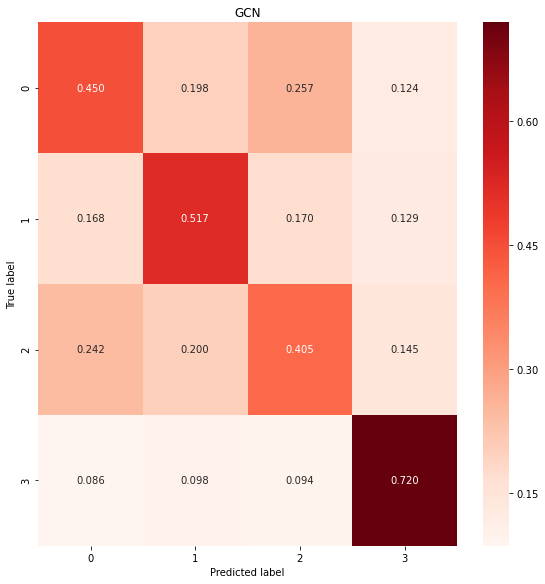

In [62]:
def plot_confusion_matrix(cm, classes=list(range(num_labels))):
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax = sns.heatmap(cm_df,
                     fmt='.3f',
                     annot=True, cmap='Reds', ax=ax)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    fig.tight_layout()
    return fig
y_test_preds = model_full_grid.predict(X_test)
print(y_test_preds.shape)
cm = metrics.confusion_matrix(y_test, np.argmax(y_test_preds, axis=1))
fig = plot_confusion_matrix(cm/cm.sum(axis=1))
fig.get_axes()[0].set_title('GCN');
for i in range(0,num_labels):
    print("Emotion mapping  {} : {} ".format(i,train_labels[i])) 


(2560, 10)
Emotion mapping  0 : angry 
Emotion mapping  1 : happy 
Emotion mapping  2 : sad 
Emotion mapping  3 : surprise 


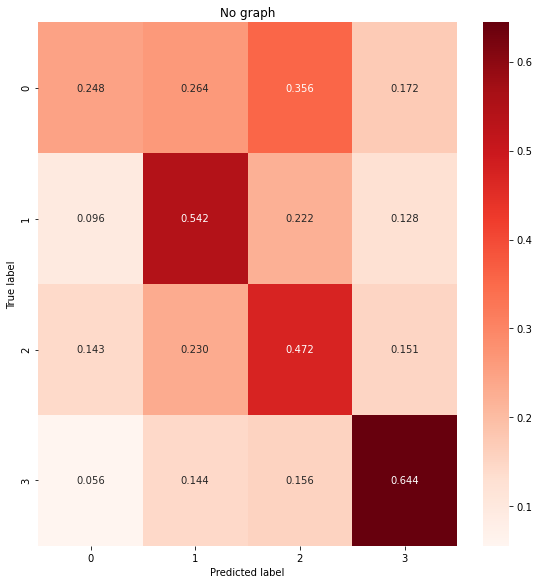

In [63]:
y_test_preds = model_no_graph.predict(X_test)
print(y_test_preds.shape)
cm = metrics.confusion_matrix(y_test, np.argmax(y_test_preds, axis=1))
fig = plot_confusion_matrix(cm/cm.sum(axis=1))
fig.get_axes()[0].set_title('No graph');
for i in range(0,num_labels):
    print("Emotion mapping  {} : {} ".format(i,train_labels[i]))

In [64]:
acc_df = {}
for model_name, model in d_emotion_models.items():
    
    y_test_preds = model.predict(X_test)
    cm = metrics.confusion_matrix(y_test, np.argmax(y_test_preds, axis=1))
    
  
    acc_per_classes = np.diag(cm/cm.sum(axis=1))

    
    acc_df[model_name] = acc_per_classes

### Finding the distribution

Number of nodes: 784; Number of edges: 250706
Number of nodes: 784; Number of edges: 250706
After removing nodes without edges:
Number of nodes: 784; Number of edges: 250706


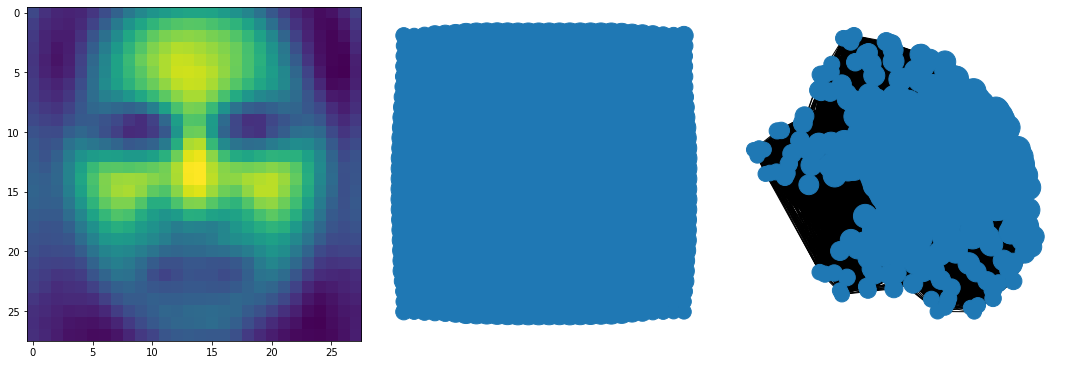

Number of nodes: 784; Number of edges: 267144
Number of nodes: 784; Number of edges: 267144
After removing nodes without edges:
Number of nodes: 784; Number of edges: 267144


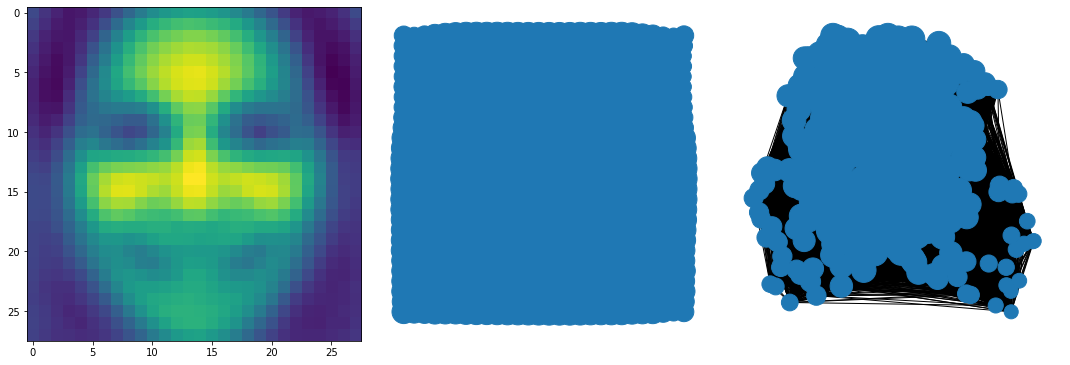

Number of nodes: 784; Number of edges: 242263
Number of nodes: 784; Number of edges: 242263
After removing nodes without edges:
Number of nodes: 784; Number of edges: 242263


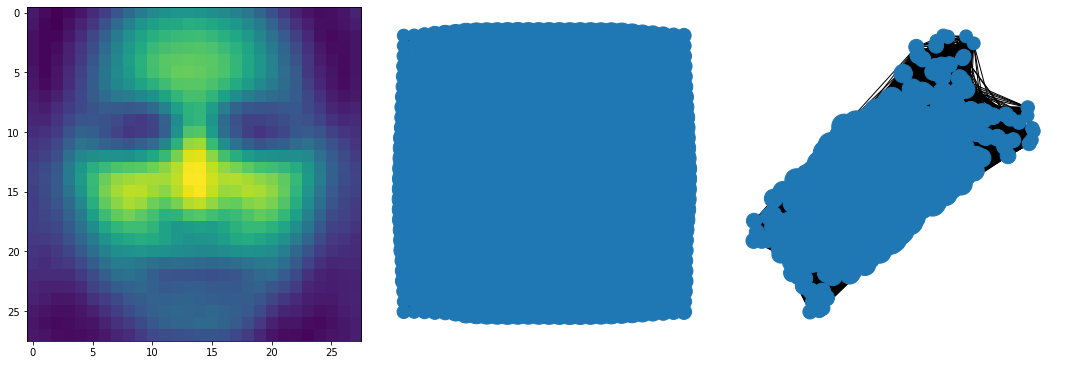

Number of nodes: 784; Number of edges: 300470
Number of nodes: 784; Number of edges: 300470
After removing nodes without edges:
Number of nodes: 784; Number of edges: 300470


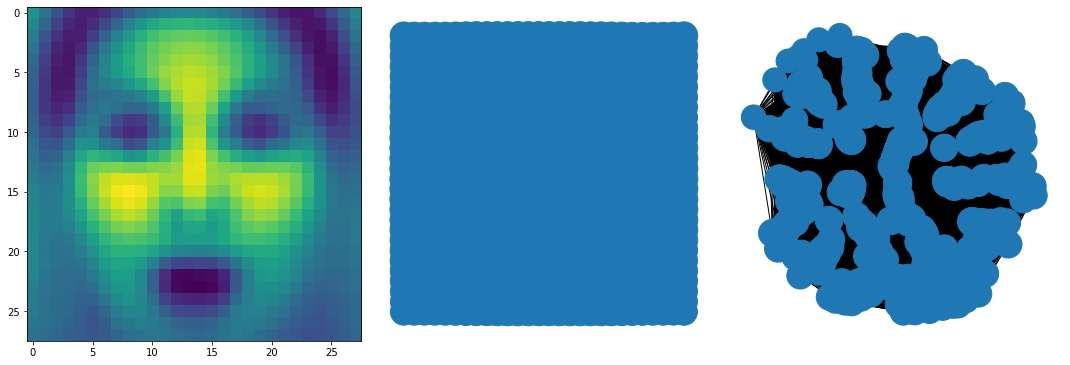

In [65]:
d_emotion_corr_graphs = {}  


for i in range(num_labels):
    mask = y_train == i

    dist = metrics.pairwise_distances(X_train[mask].reshape(-1, 784).T, metric='cosine', n_jobs=-2)

    W = sp.coo_matrix(1 - dist, dtype=np.float32)

    # No self-connections.
    W.setdiag(0)

    # Non-directed graph.
    bigger = W.T > W
    W = W - W.multiply(bigger) + W.T.multiply(bigger)

    assert W.nnz % 2 == 0
    assert np.abs(W - W.T).mean() < 1e-10
    assert type(W) is sp.csr.csr_matrix

    fig, axes = plt.subplots(figsize=(15, 5), ncols=3)

    x_train_i_avg = X_train[mask].mean(axis=0).flatten()
    axes[0].imshow(x_train_i_avg.reshape(28, 28))

    # thresholding
    W = W.multiply(W > 0.8)

    d_emotion_corr_graphs[i] = W

    axes[1] = create_graph(W, ax=axes[1], size_factor=1)

    axes[2] = create_graph(W, ax=axes[2], size_factor=1, spring_layout=True)
    fig.tight_layout()
    plt.show()


Number of nodes: 784; Number of edges: 3198
Number of nodes: 784; Number of edges: 250706
Number of nodes: 784; Number of edges: 3198
Number of nodes: 784; Number of edges: 267144
Number of nodes: 784; Number of edges: 3198
Number of nodes: 784; Number of edges: 242263
Number of nodes: 784; Number of edges: 3198
Number of nodes: 784; Number of edges: 300470


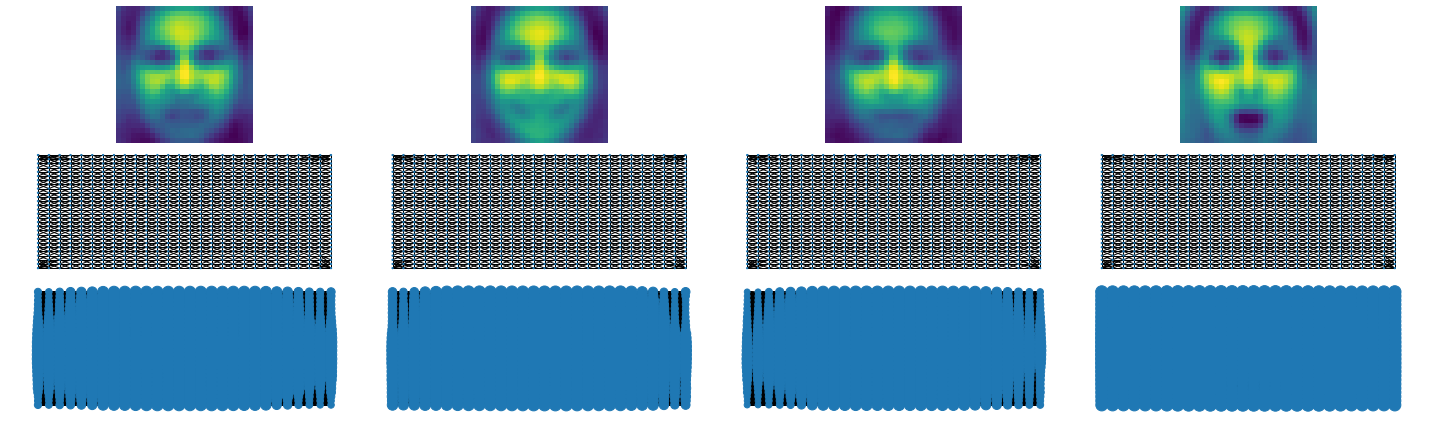

In [66]:
fig, axes = plt.subplots(figsize=(20, 6), nrows=3, ncols=num_labels)

for i in range(num_labels):
    mask = y_train == i
    x_train_i_avg = X_train[mask].mean(axis=0).flatten()
    axes[0, i].imshow(x_train_i_avg.reshape(28, 28))
    axes[0, i].axis('off')
    
    axes[1, i] = create_graph(d_emotion_graphs[i], ax=axes[1, i], size_factor=0.2)
    axes[2, i] = create_graph(d_emotion_corr_graphs[i], ax=axes[2, i], size_factor=0.2)
    
    
fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
 

In [67]:
y_test_preds = model_full_grid.predict(X_test)
cm = metrics.confusion_matrix(y_test, np.argmax(y_test_preds, axis=1))
acc_per_class_full_model = np.diag(cm/cm.sum(axis=1))
acc_per_class_full_model
for i in range(0,num_labels):
    print("Emotion efficency : {} :{} ".format(train_labels[i],acc_per_class_full_model[i]))

Emotion efficency : angry :0.4496240601503759 
Emotion efficency : happy :0.5168 
Emotion efficency : sad :0.4047244094488189 
Emotion efficency : surprise :0.7196850393700788 
